# Data Science Pipeline
## Preliminary Goals
The Data Science pipeline can be a complex beast to tackle; from thinking about which data to use all the way to predictions and heavy analysis.

The pipeline consists of the following steps:
* Data Collection
* Data Management/Tidying
* Exploratory Analysis
* Hypothesis Testing
* Communication of Insights

This demonstration will walk through all of the steps, explaining first and foremost what can help you get into the correct headspace to approach each one! While the code may be specific to my chosen dataset and goals, the ideas within are extensible to data science as a whole.

The preliminary step to everything next is to think of what data you want to look at. It has to exist to be collected and analyzed.

## Speedrun Analysis
Analyzing how timed speedruns of the game Dark Souls 3 have advanced since its release on March 24, 2016.

This data (and related analysis) will be compared against the dates in which speed-enhancing explots or techniques were developed, to show their effects over time.

speedrun.com, the data source I have chosen, has a well-documented API for sourcing specific data. The breadth of information they have to store in dynamic tables (with copious amounts of metadata) means that scraping this data without an API would take an unreasonable amount of time without more experience.

API documentation found at https://github.com/speedruncomorg/api

## Data Collection
The aforementioned API lets us access data by pulling in json-formatted information. json interacts very well with Python as a simple and scalable data "structure." 

In [28]:
# To begin, this is where we will start (and continue to add) libraries
# necessary to collect, organize, and analyze our data.
import requests as req
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import datetime as dt
import matplotlib.pyplot as plt
import json
import seaborn as sns

### ALL CURRENT RUNS
I would like to find all current runs submitted for the game Dark Souls III,
under the run category Any%. According to the API, that information is located at this link:

https://www.speedrun.com/api/v1/runs?game=k6qg0xdg&max=200

Exploring these json structures through the browser first, before import, will allow you to become familiar with the overall data structure and which patterns it holds.

Once we explore the structure, we can pick out exactly what information we need/want to analyze. This makes it so that we are not dealing with an overload of unnecessary data.

In Pandas, storing this information takes the form of a large table known as a dataframe. 

The columns of the dataframe holding run data will be:

**index** - index of run (index of dataframe, not actual column)

**players** - tuple containing status of player (user or guest) and 'None' if guest or their unique ID if user.

**date** - date of run, not of submission.

**times.primary_t** - primary submission time, used for leaderboard.

**times.ingame_t** - ingame time only, just in case. In the case of techniques involving quitting the game, restarting the game, etc.; ingame time is used to describe only the amount of time spent in-game.

The columns above are just features of the internal json, how the site is designed. The structure of the dataframe is not necessarily decided beforehand, but after we intake and prune the data.

In [29]:
# Initializing empty dataframe for harvest method
runsdf = pd.DataFrame()

When looking at the pages online, note that they are paginated. In this specific structure, that means that there is a section for raw data and a section that links to the next and previous pages of the data.

Because this is a structure choice, and not an inherent feature of json, the below method is necessary to get all of the data recursively and in one call.

Knowing the structure means that when we reach end-of-page, we know to:
1. If it has a 'prev' and a 'next' in the list of links, get the second link (which is 'next').
2. If it is the first page, it will not have a 'prev', but there will be a 'next' in the first slot of the list. If so, get the link.
3. If there is only 'prev' and no 'next', the end of pages is reached, and we can return the full dataframe.

In [30]:
## HARVEST ##
# This method relies on the structure of the speedrun.com API
# It is designed to get the json data from each runs page,
# normalize it into a pandas dataframe, and append it to the 
# above empty dataframe (or whichever dataframe is supplied).
def add_runs(url, df):
    r = req.get(url)
    data = r.json()
    # ignore_index true to get resultant dataframe with fresh indices.
    df = df.append(pd.json_normalize(data['data']), ignore_index = True)
    if len(data['pagination']['links']) == 2:
        return add_runs(data['pagination']['links'][1]['uri'], df)
    elif data['pagination']['links'][0].get('rel') == 'next':
        return add_runs(data['pagination']['links'][0]['uri'], df)
    else:
        return df

Python's 'json' library is very good at taking in raw json and turning it into a nested dict with easily-iterable keys. Printing and exploring this dict ('data' in the above method) manually before intaking the data to Pandas is necessary once again to be familiar with the structure and where the data we want is located.

In [31]:
# using the 'page 0' link to the Any% data to begin.
runsdf = add_runs('https://www.speedrun.com/api/v1/runs?game=k6qg0xdg&max=200', runsdf)

While it would be foolish to try and vet the entire dataset by eye, displaying more than the head or tail of the dataframe is useful for knowing what units the data is in, making sure that all columns are present, and learning the names of the columns to be called.

In [32]:
with pd.option_context('display.max_rows',100, 'display.max_columns', 10):
    display(runsdf)

,id,weblink,game,level,category,...,system.region,status.reason,splits.rel,splits.uri,videos
0,oy2ej8wy,https://www.speedrun.com/darksouls3/run/oy2ej8wy,k6qg0xdg,None,xk9lx0gk,...,None,NaN,NaN,NaN,NaN
1,2yw6gppm,https://www.speedrun.com/darksouls3/run/2yw6gppm,k6qg0xdg,None,xk9lx0gk,...,None,NaN,NaN,NaN,NaN
2,pm3x0v6m,https://www.speedrun.com/darksouls3/run/pm3x0v6m,k6qg0xdg,None,xk9lx0gk,...,None,no vid,NaN,NaN,NaN
3,0y6xg26y,https://www.speedrun.com/darksouls3/run/0y6xg26y,k6qg0xdg,None,n2y143z2,...,None,can you reupload to youtube? I don't have prem...,NaN,NaN,NaN
4,8yv0npoz,https://www.speedrun.com/darksouls3/run/8yv0npoz,k6qg0xdg,None,n2y143z2,...,None,duplicate,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1756,z1rewg9m,https://www.speedrun.com/darksouls3/run/z1rewg9m,k6qg0xdg,None,7kjz1ond,...,None,NaN,NaN,NaN,NaN
1757,m7drp60m,https://www.speedrun.com/darksouls3/run/m7drp60m,k6qg0xdg,None,xk9lx0gk,...,None,https://youtu.be/Rzoui9rKVi8?t=300 Runners are...,NaN,NaN,NaN
1758,zp17revz,https://www.speedrun.com/darksouls3/run/zp17revz,k6qg0xdg,None,jdzvw3xk,...,None,NaN,NaN,NaN,NaN
1759,mkgj5e5y,https://www.speedrun.com/darksouls3/run/mkgj5e5y,k6qg0xdg,None,xk9r81gk,...,None,NaN,NaN,NaN,NaN


## Data Management/Tidying

In [33]:
# turning 'players' column into a tuple (x, y), where
# 'x' is either 'user' or 'guest', and y is either a userID or 'none' respectively.
runsdf['players'] = runsdf['players'].apply(lambda x: (x[0].get('rel'), x[0].get('id')))

Missing data presents itself in many ways, 

In [34]:
# marking data outside of our interest as 'NA' so it can be dropped when plotting.
runsdf.loc[(runsdf['times.primary_t'] < 1900), 'times.primary_t'] = pd.NA
runsdf.loc[(runsdf['times.primary_t'] > 17000), 'times.primary_t'] = pd.NA
# removing rejected runs as well
runsdf.loc[(runsdf['status.status'] == 'rejected'), 'status.status'] = pd.NA
# changing date column to real datetime
runsdf['date'] = pd.to_datetime(runsdf['date'], format='%Y-%m-%d')

In [35]:
# cutting down dataframe columns to described format, metadata largely discarded.
prunedrsdf = runsdf[['id', 'players','date','times.primary_t','times.ingame_t']]
prunedrsdf.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1698 entries, 0 to 1760
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               1698 non-null   object        
 1   players          1698 non-null   object        
 2   date             1698 non-null   datetime64[ns]
 3   times.primary_t  1698 non-null   object        
 4   times.ingame_t   1698 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 79.6+ KB


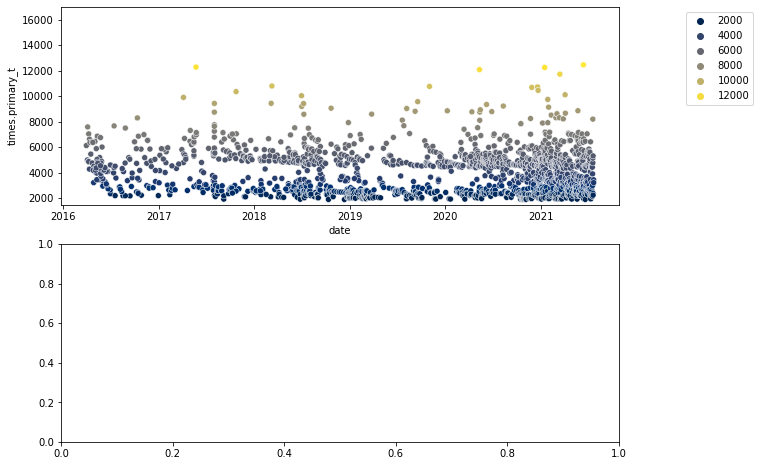

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# using dropna() to prune the data for plotting.
sns.scatterplot(data=prunedrsdf.dropna(), x='date',y='times.primary_t', ax=ax[0], palette='cividis', hue='times.primary_t')
ax[0].set_ylim(bottom=1500, top=17000)
ax[0].legend(bbox_to_anchor=(1.25, 1), loc='upper right')
plt.show()

### CURRENT LEADERBOARD

In [37]:
dks3lb = req.get('https://www.speedrun.com/api/v1/leaderboards/k6qg0xdg/category/n2y143z2')

In [38]:
dks3lb = req.get('https://www.speedrun.com/api/v1/leaderboards/pd0wq31e/category/7kjrn323')

In [39]:
jsonlbs = dks3lb.json()

In [40]:
# cutting out the unnecessary accesses
leaderboard = jsonlbs['data']['runs']

In [41]:
# flattening json to dataframe. we will prune this in a moment for the
# relatively low number of columns we need.
leaderdf = pd.json_normalize(leaderboard)

In [42]:
# turning 'players' column into just the id of the player
leaderdf['run.players'] = leaderdf['run.players'].apply(lambda x: x[0].get('id'))

In [43]:
# changing date column to real datetime
leaderdf['run.date'] = pd.to_datetime(leaderdf['run.date'], format='%Y-%m-%d')
leaderdf['run.times.primary_t'] = leaderdf['run.times.primary_t'].apply(lambda x: x/60)

In [44]:
prunedlbdf = leaderdf[['place','run.id','run.date','run.times.primary_t', 'run.players']]

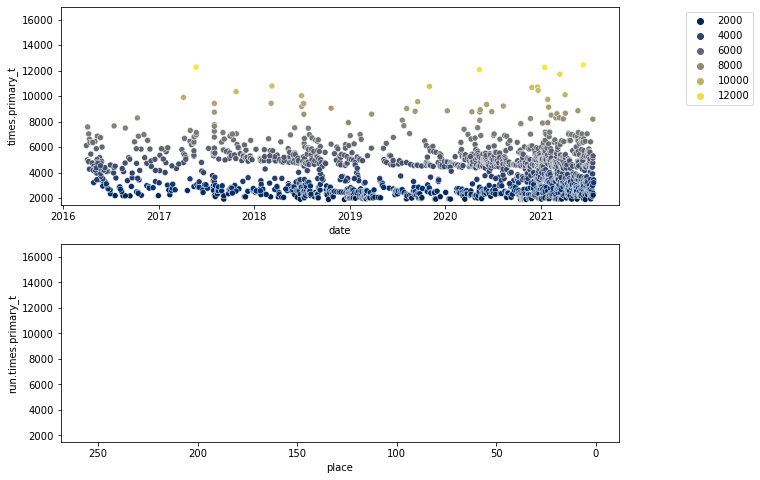

In [45]:
sns.lineplot(data=prunedlbdf, x='place', y='run.times.primary_t' ,color='hotpink', ax=ax[1])
ax[1].invert_xaxis()
ax[1].set_ylim(top=17000, bottom=1500)
fig